# Introduction to the Gaussian process regression 
## The Practice ploblem


Course
- SURF 2016

Lecturer :
- Georgios Karagiannis, Department of Mathematics, Purdue

July 8, 2016

Objective :

- We wish to build a Gaussian Process regression --a probabilistic surrogate model-- in order to be able to emulate the output of the Piston Simulator, with respect to specified inputs.

Related material:

    Readings :
    
    - Rasmussen, Carl Edward. "Gaussian processes in machine learning." In Advanced lectures on machine learning, pp. 63-71. Springer Berlin Heidelberg, 2004. 	
        - see http://www.GaussianProcess.org/gpml
        - Chapters: 2, 4, 5.1, & 5.4.2

    - Slides provided
    
    Software :
    
    - R-cran (https://cran.r-project.org/)
    - R packages 
        - DiceKrigin (https://cran.r-project.org/web/packages/DiceKriging/index.html)
        - lhs (https://cran.r-project.org/web/packages/lhs/index.html)
    - Roustant, Olivier, David Ginsbourger, and Yves Deville. "DiceKriging, DiceOptim: Two R packages for the analysis of computer experiments by kriging-based metamodeling and optimization." (2012).
        - Plus dependences ...

# The robot arm simulation function model

The robot arm function, used commonly in neural network papers, models the position of a robot arm which has four segments. While the shoulder is fixed at the origin, the four segments each have length $L_i$, and are positioned at an angle $\theta_i$ (with respect to the horizontal axis), for $i = 1,..., 4$. 

The response is the distance from the end of the robot arm to the origin, on the $(u, v)$-plane. 



$$
C(x) = \sqrt{u^2+u^2}
$$

$$
u = \sum_{i=1}^4 L_i \cos(\sum_{j=1}^i \theta_j) )
$$

$$
v = \sum_{i=1}^4 L_i \sin (\sum_{j=1}^i \theta_j) )
$$

The input variables and their usual input ranges are: 
<pre>

--------------------------------------------------

θ1 ∈ [0, 2π] | angle of the first arm segment
θ2 ∈ [0, 2π] | angle of the second arm segment
θ3 ∈ [0, 2π] | angle of the third arm segment
θ4 ∈ [0, 2π] | angle of the fourth arm segment
L1 ∈ [0, 1]  | length of the first arm segment
L2 ∈ [0, 1]  | length of the second arm segment
L3 ∈ [0, 1]  | length of the third arm segment
L4 ∈ [0, 1]  | length of the fourth arm segment
--------------------------------------------------

</pre>

=> As a result we wish to emulate the function $f(\theta_1,\theta_2,\theta_3,\theta_4,L_1,L_2,L_3,L_4) := C(\theta_1,\theta_2,\theta_3,\theta_4,L_1,L_2,L_3,L_4)$.

Reference:
http://www.sfu.ca/~ssurjano/piston.html

An, J., & Owen, A. (2001). Quasi-regression. Journal of Complexity, 17(4), 588-607.




## Software preparation

In [1]:
# DOWNLOAD THE R PACKAGES REQUIRED
install.packages('DiceKriging', repos = "http://cran.us.r-project.org")
install.packages('lhs', repos = "http://cran.us.r-project.org")
# install.packages('tcltk', repos = "http://cran.us.r-project.org")
# install.packages('aplpack', repos = "http://cran.us.r-project.org")

Installing package into ‘/export/users/gkaragia/R/x86_64-redhat-linux-gnu-library/3.3’
(as ‘lib’ is unspecified)
Warning message:
In install.packages("DiceKriging", repos = "http://cran.us.r-project.org"): installation of package ‘DiceKriging’ had non-zero exit statusInstalling package into ‘/export/users/gkaragia/R/x86_64-redhat-linux-gnu-library/3.3’
(as ‘lib’ is unspecified)
Installing package into ‘/export/users/gkaragia/R/x86_64-redhat-linux-gnu-library/3.3’
(as ‘lib’ is unspecified)
Warning message:
In install.packages("lhs", repos = "http://cran.us.r-project.org"): installation of package ‘lhs’ had non-zero exit status

In [1]:
# LOAD THE R PACKAGES REQUIRED
library('lhs')
library('DiceKriging')
# library('tcltk')
# library('aplpack')

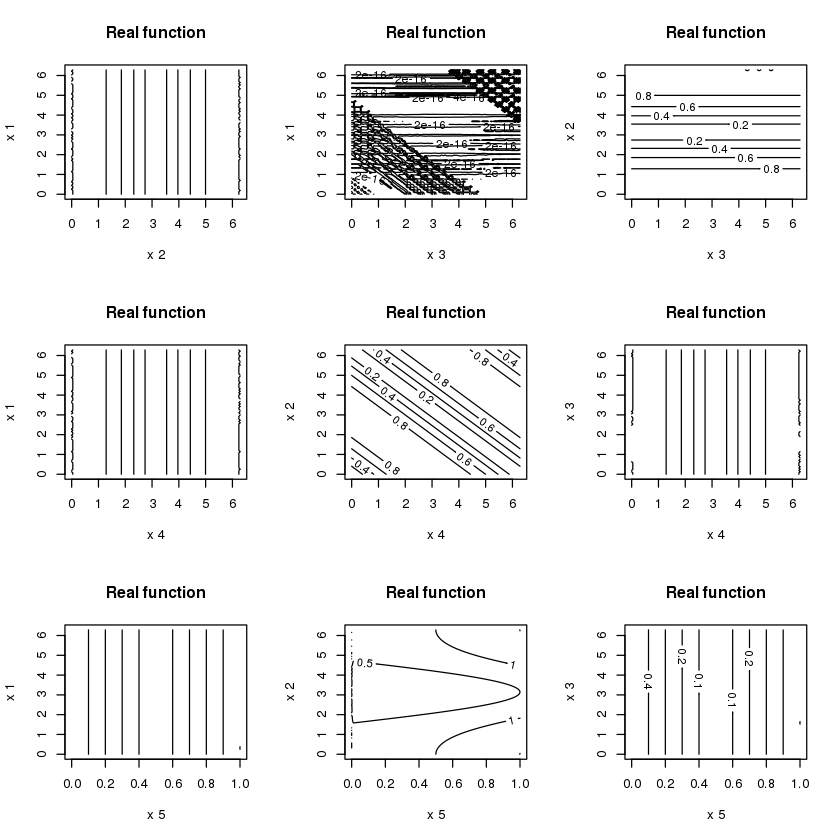

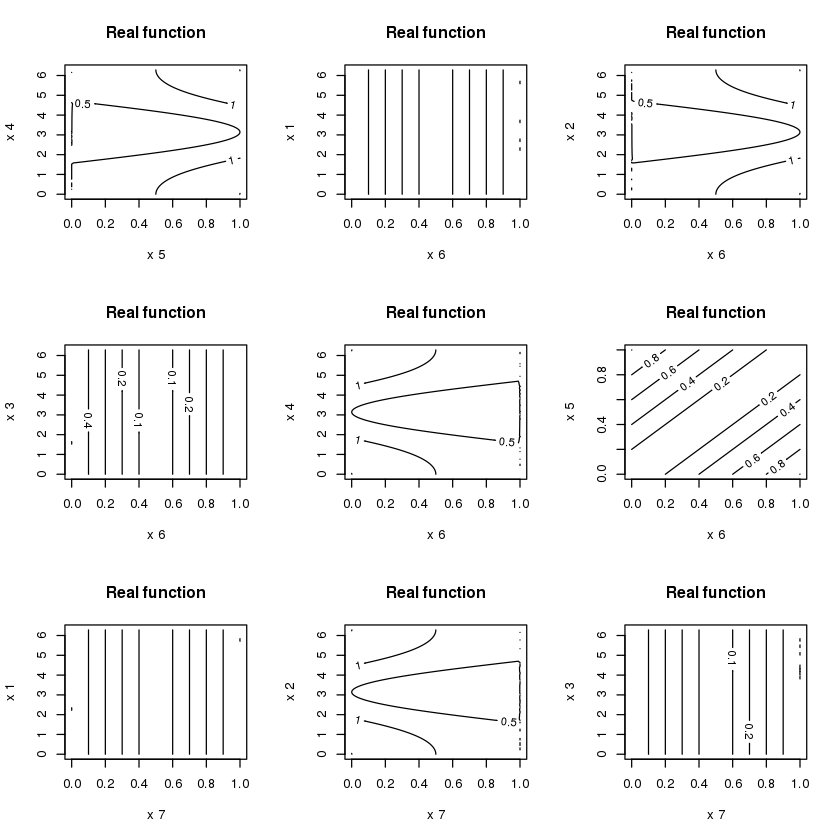

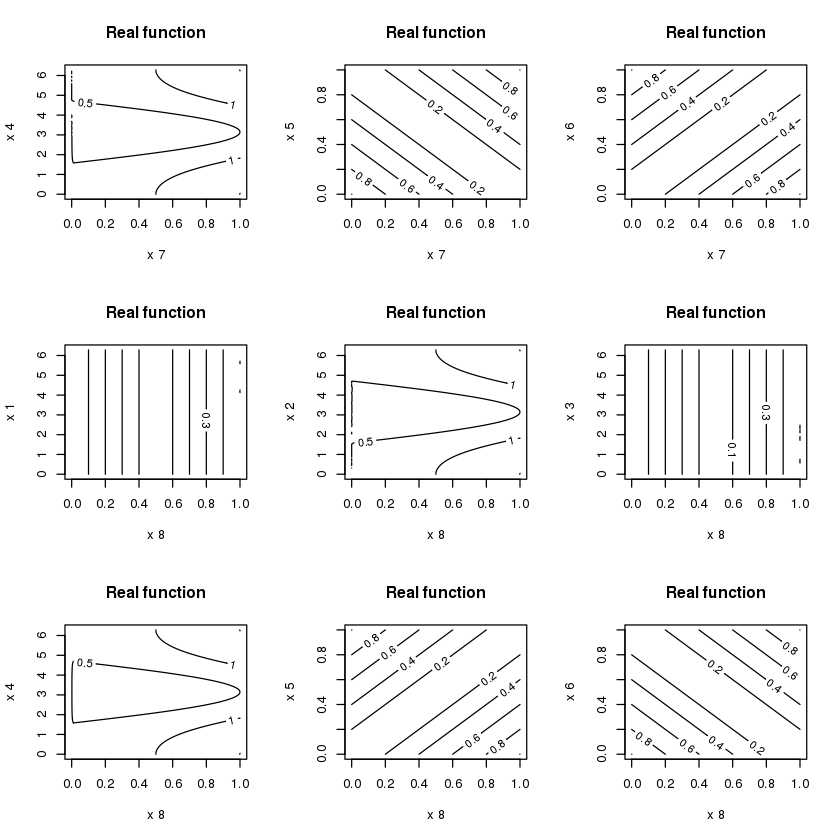

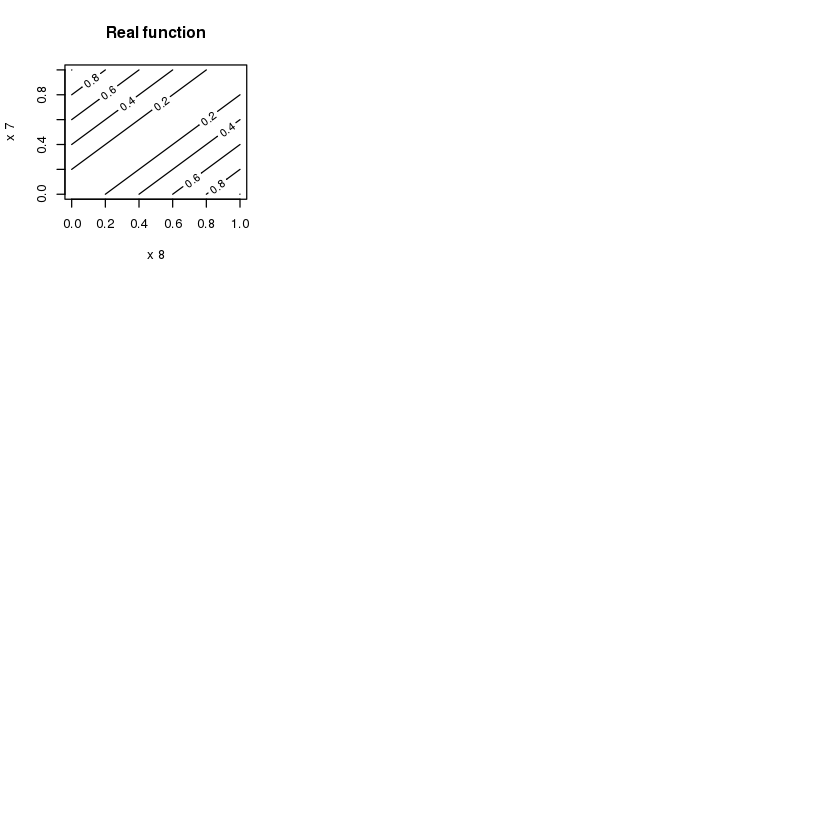

In [3]:
# THIS IS THE SIMULATOR AND THE MIN AND MAX OF THE INPUTS

robot <- function(xx) {
  ##########################################################################
  #
  # ROBOT ARM FUNCTION
  #
  # Authors: Sonja Surjanovic, Simon Fraser University
  #          Derek Bingham, Simon Fraser University
  # Questions/Comments: Please email Derek Bingham at dbingham@stat.sfu.ca.
  #
  # Copyright 2013. Derek Bingham, Simon Fraser University.
  #
  # THERE IS NO WARRANTY, EXPRESS OR IMPLIED. WE DO NOT ASSUME ANY LIABILITY
  # FOR THE USE OF THIS SOFTWARE.  If software is modified to produce
  # derivative works, such modified software should be clearly marked.
  # Additionally, this program is free software; you can redistribute it 
  # and/or modify it under the terms of the GNU General Public License as 
  # published by the Free Software Foundation; version 2.0 of the License. 
  # Accordingly, this program is distributed in the hope that it will be 
  # useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
  # of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU 
  # General Public License for more details.
  #
  # For function details and reference information, see:
  # http://www.sfu.ca/~ssurjano/
  #
  ##########################################################################
  #
  # OUTPUT AND INPUTS:
  #
  # y = distance from the end of the arm to the origin
  # xx = c(theta1, theta2, theta3, theta4, L1, L2, L3, L4)
  #
  #########################################################################
  
  theta <- xx[1:4]
  L     <- xx[5:8]
  
  thetamat <- matrix(rep(theta,times=4), 4, 4, byrow=TRUE)
  thetamatlow <- thetamat
  thetamatlow[upper.tri(thetamatlow)] <- 0
  sumtheta <- rowSums(thetamatlow)
  
  u <- sum(L*cos(sumtheta))
  v <- sum(L*sin(sumtheta))
  
  y <- (u^2 + v^2)^(0.5)
  return(y)
}
input_min <- c(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 )
input_max <- c(2*pi, 2*pi, 2*pi, 2*pi, 1.0, 1.0, 1.0, 1.0)
input_d <- length(input_min)

myfun <- robot

# PLOT THE REAL FUNCTION TO SEE HOW IT LOOKS LIKE

par(mfrow = c(3,3))
for (i in 1:input_d) {
    for ( j in 1:input_d ) 
        if(i>j) {
        n.grid <- 100 ;
        x1.grid <-seq(input_min[i],input_max[i],length.out=n.grid) ;
        x2.grid <-seq(input_min[j],input_max[j],length.out=n.grid) ;
        X.grid <- expand.grid( x1=x1.grid,  x2=x2.grid )
        myfun2d<-function(xx){ 
                            zz<-0.5*(input_min+input_max) ; 
                            zz[i]<-xx[1]; zz[j]<-xx[2]; 
                            return(myfun(zz)) 
                    }
        y.grid <- apply(X.grid,1,myfun2d)
    contour(x1.grid, x2.grid, matrix(y.grid, n.grid, n.grid), 5, 
            main = "Real function", 
            xlab = paste("x", as.character(i)), 
            ylab = paste("x", as.character(j)),
            xlim = c(input_min[i],input_max[i]), 
            ylim = c(input_min[j],input_max[j]))
    }
}

## Generate a training data-set

Generate a training data-set $D={(x_i,y_i);i=1,...,n}$  of size $n=20$ via a LHS.

## Compare different GP regression models

Use the diagnostics we leant, and compare Gaussian process regression models deffering on the prior linear trend structure or the covariance function

## Choose the 'Best' model

## Check the validity of the chossen 'Best' model

## Print the estimates of the hyperparameters

## Plot the posterior GPR mean and variance, as well as the real function (in contour plots)